# Previsão de Churn no Serviço de Cartão de Crédito do Banco
Neste projeto, irei construir um <b>modelo de aprendizado de máquina para prever a probabilidade de churn dos clientes em um serviço de cartão de crédito do banco.</b> Envolve <b>aprendizado supervisionado (usando um conjunto de treinamento rotulado) para classificação</b>, onde o <b>alvo</b> é <b>1</b> se o <b>cliente cancelar</b>, caso contrário, <b>0.</b>

Utilizarei o seguinte <b>pipeline</b> baseado no <b>framework CRISP-DM:</b>

<b>1. Definir o problema de negócio.</b><br>
<b>2. Coletar os dados e obter uma visão geral dos mesmos.</b><br>
<b>3. Dividir os dados em conjuntos de treino e teste.</b><br>
<b>4. Explorar os dados (análise exploratória de dados)</b><br>
<b>5. Engenharia de recursos, limpeza de dados e pré-processamento.</b><br>
<b>6. Treinamento e comparação de modelos, seleção e ajuste de recursos.</b><br>
<b>7. Teste e avaliação do modelo de produção final.</b><br>
<b>8. Concluir e interpretar os resultados do modelo.</b><br>
<b>9. Implantar.</b><br>

Neste <b>notebook</b>, realizarei <b>modelagem de aprendizado de máquina, cobrindo os passos de 5 a 8 do pipeline acima.</b> O principal <b>objetivo</b> aqui é <b>construir um modelo que possa prever com precisão a probabilidade de um cliente cancelar.</b> Uma vez que eu construa esse modelo, o <b>banco pode planejar estratégias para retenção de clientes, mantendo uma receita saudável. Adquirir novos clientes é mais caro do que manter os existentes.</b> Além disso, abordarei esses passos em detalhes abaixo, explicando por que estou tomando cada decisão.

### Importando as bibliotecas

In [2]:
# Data manipulation and visualization.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Modelling
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
import optuna
import shap
shap.initjs()

# Filter warnings.
import warnings
warnings.filterwarnings('ignore')

# Utils
from src.modelling_utils import *

### Visualization Settings
%matplotlib inline

#mpl.style.use('ggplot') 

mpl.rcParams['axes.facecolor']      = 'white'
mpl.rcParams['axes.linewidth']      = 1
mpl.rcParams['xtick.color']         = 'black'
mpl.rcParams['ytick.color']         = 'black'
mpl.rcParams['grid.color']          = 'lightgray'
#mpl.rcParams['figure.dpi']          = 150
mpl.rcParams['axes.grid']           = True
mpl.rcParams['font.size']           = 12

# Palette Setting
color_palette = ['#023047', '#e85d04', '#0077b6', '#ff8200', '#0096c7', '#ff9c33']
# Setting as the palette
sns.set_palette(sns.color_palette(color_palette))
# Display
sns.color_palette(color_palette)

[(0.00784313725490196, 0.18823529411764706, 0.2784313725490196),
 (0.9098039215686274, 0.36470588235294116, 0.01568627450980392),
 (0.0, 0.4666666666666667, 0.7137254901960784),
 (1.0, 0.5098039215686274, 0.0),
 (0.0, 0.5882352941176471, 0.7803921568627451),
 (1.0, 0.611764705882353, 0.2)]

### Ler o conjunto de dados

In [3]:
data_path = '../input/BankChurners.csv'
df = pd.read_csv(data_path)

In [4]:
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


- Vou renomear as colunas para um formato padrão a fim de facilitar a manipulação dos dados. Attrition_flag será renomeado como churn_flag para fins de interpretação. Além disso, vou convertê-lo para um formato binário, para se adequar aos algoritmos de aprendizado de máquina.

In [6]:
df.columns = [x.lower() for x in df.columns]

In [7]:
df.rename(columns={'attrition_flag': 'churn_flag'}, inplace=True)
df['churn_flag'] = df['churn_flag'].map({'Attrited Customer': 1, 'Existing Customer': 0})

# Attrited Customer = Cliente desativado
# Existing Customer = Cliente existente

### Dividindo os dados em conjuntos de treinamento e teste
- Primeiro, vou dividir os dados em conjuntos de treinamento e teste. O conjunto de teste deve conter dados que o modelo nunca viu antes.

- Essa divisão evitará o vazamento de dados, que ocorre quando informações do conjunto de teste ou dados futuros vazam inadvertidamente para o processo de treinamento, levando a uma estimativa de desempenho excessivamente otimista, comprometendo a capacidade do modelo de generalizar para novos dados nunca vistos.

- Uma boa prática para proteger o modelo contra vazamento de dados é executar fit_transform nos dados de treinamento e apenas transform nos dados de teste ao aplicar etapas de pré-processamento após a divisão.

- Vou especificar stratify=y para que a função train_test_split garanta que o processo de divisão mantenha a mesma porcentagem de cada classe alvo em ambos os conjuntos de treinamento e teste. Isso é particularmente útil ao lidar com conjuntos de dados desbalanceados, que é o caso, pois há mais clientes existentes do que clientes que abandonaram o serviço.

In [8]:
X = df.drop(columns=['churn_flag'])
y = df['churn_flag'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [9]:
print(f'Formato do conjunto de dados preditor de treinamento: {X_train.shape}.')
print(f'Formato do conjunto de dados alvo de treinamento: {y_train.shape}.')
print(f'Formato do conjunto de dados preditor de teste: {X_test.shape}.')
print(f'Formato do conjunto de dados alvo de teste: {y_test.shape}.')

Formato do conjunto de dados preditor de treinamento: (8101, 22).
Formato do conjunto de dados alvo de treinamento: (8101,).
Formato do conjunto de dados preditor de teste: (2026, 22).
Formato do conjunto de dados alvo de teste: (2026,).


In [10]:
print(f'Proporção da variável alvo no conjunto de treinamento: ')
print(f'{y_train.value_counts(normalize=True)}')
print(f'\nProporção da variável alvo no conjunto de teste: ')
print(f'{y_test.value_counts(normalize=True)}')

Proporção da variável alvo no conjunto de treinamento: 
churn_flag
0    0.839279
1    0.160721
Name: proportion, dtype: float64

Proporção da variável alvo no conjunto de teste: 
churn_flag
0    0.839585
1    0.160415
Name: proportion, dtype: float64


Preservação das proporções das classes alvo.

Isso é importante para garantir que o modelo seja treinado em dados que representem de forma precisa a distribuição real das classes e que sua capacidade de generalização não seja comprometida.

# 5. Engenharia de Recursos, Limpeza e Pré-processamento de Dados
Para ajustar os algoritmos de aprendizado de máquina, é necessário aplicar algumas transformações aos dados. Não há valores ausentes nos dados e os outliers não representam informações inconsistentes. Assim, precisarei apenas aplicar técnicas de pré-processamento, mencionadas abaixo.

Considerando que os modelos lineares e baseados em árvore requerem técnicas de pré-processamento distintas, construirei dois pré-processadores:
- Para o pré-processador de modelos baseados em árvore, não aplicarei nenhuma técnica de pré-processamento a recursos numéricos porque esses modelos não exigem escalonamento de recursos. 

- Para os recursos categóricos com relações ordinais (nível de educação, categoria de renda e categoria de cartão), aplicarei codificação ordinal, a fim de preservar essa característica. 

- Para o recurso categórico restante (estado civil), aplicarei codificação de destino porque a codificação one-hot pode ser prejudicial para modelos baseados em árvore devido à representação esparsa e aumento da dimensionalidade. A codificação one-hot será aplicada apenas ao gênero, pois será convertido em uma única variável binária, não aumentando a dimensionalidade.

- Para os modelos lineares, aplicarei escalonamento padrão aos recursos numéricos porque esses algoritmos utilizam cálculos baseados em distância ou algoritmos de otimização, como gradiente descendente, sendo sensíveis à escala. 

- Para os recursos categóricos, aplicarei codificação one-hot. Isso ocorre porque os modelos lineares apresentam a suposição de linearidade. Os modelos lineares aproveitam essa técnica de codificação porque, ao criar dummies para cada categoria, nós as tratamos individualmente, atribuindo um peso distinto e garantindo a presença de linearidade 1 quando essa categoria está presente, caso contrário, 0.

Uma observação importante é que, uma vez que estou focando no poder preditivo, não gastarei muito tempo procurando por problemas de multicolinearidade ou discretizando variáveis contínuas numéricas (tarefas para melhorar o desempenho dos modelos lineares, atendendo às suas suposições) porque minha ideia é usar um modelo robusto como o LightGBM. Vou testar modelos lineares apenas para ver se seus desempenhos superam esse poderoso algoritmo de boosting de gradiente. Se for esse o caso, eu os usaria, equilibrando o custo computacional.

**Engenharia de Recursos:**
Para extrair o máximo de informações dos recursos disponíveis, farei alguma engenharia de recursos, que já está embutida no pré-processador.
Vou criar os seguintes recursos:

- Recursos de proporção: products_per_dependent, trans_amt_per_dependent, trans_ct_per_dependent, trans_amt_per_products, trans_ct_per_products, avg_trans_amt, credit_util_rate, proportion_inactive_months, products_per_tenure, products_per_contacts, dependents_per_contacts, trans_ct_per_contacts, products_per_inactivity, dependents_per_inactivity, trans_ct_per_inactivity, trans_amt_per_credit_limit, age_per_tenure, trans_ct_per_tenure, trans_amt_per_tenure.

- Recursos de soma: total_spending, education_income_levels (ordinal), inactivity_contacts.
Considerando que essas são variáveis numéricas, todas serão escalonadas para a etapa de validação cruzada k-fold estratificada (comparação de modelos).
Eventualmente, outros recursos serão adicionados. Esses recursos acima já podem capturar relacionamentos e padrões ocultos. Além disso, eles fazem sentido no contexto do negócio. Isso é algo a ser levado em consideração ao realizar a engenharia de recursos.

Considerações sobre algumas nuances vistas na EDA:
- Vou deixar a categoria 'desconhecido' em income_category, marital_status e education_level como outra categoria dessas variáveis. Isso ocorre porque vi na EDA que esta categoria apresenta discriminação entre churners e não churners. Especificamente, em marital_status, apresenta a maior taxa de churn. Para education_level e income_category, apresenta as segundas maiores taxas de churn. Assim, não farei nenhuma imputação. A imputação introduziria viés e perda de informação.

- Vou deixar a variável card_category nos dados porque, embora seja altamente desbalanceada, foi observado que as categorias Gold e Silver apresentam taxas de churn mais altas. Como pretendo construir modelos robustos como o LightGBM, com foco no poder preditivo, manterei essa variável e aplicarei um método de seleção de recursos para removê-la caso seja inútil.

- Vou eliminar avg_open_to_buy porque observei que está perfeitamente correlacionado positivamente com credit_limit, tornando sua informação redundante.

- Vou eliminar CLIENTNUM porque tem um valor único para cada registro.

- Vou eliminar duas variáveis específicas porque não tenho acesso ao que significam e parecem ser resultados de um modelo de aprendizado de máquina Naive Bayes.
Novamente, não tratarei de questões como multicolinearidade porque o foco está na construção de modelos robustos como o LightGBM, tentando atingir o máximo poder preditivo.

Todo o pré-processamento mencionado acima é feito por classes transformadoras, definidas em "modelling_utils.py". Isso nos permite integrar tudo em um único pipeline sklearn, facilitando a implantação do modelo em ambiente de produção.

In [11]:
X_train.head()

,clientnum,customer_age,gender,dependent_count,education_level,marital_status,income_category,card_category,months_on_book,total_relationship_count,...,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio,naive_bayes_classifier_attrition_flag_card_category_contacts_count_12_mon_dependent_count_education_level_months_inactive_12_mon_1,naive_bayes_classifier_attrition_flag_card_category_contacts_count_12_mon_dependent_count_education_level_months_inactive_12_mon_2
2856,787504158,36,F,0,Unknown,Married,Less than $40K,Blue,24,4,...,2570.0,2230,340.0,0.686,1755,42,0.448,0.868,0.000170,0.99983
6515,718279008,44,M,3,High School,Single,$60K - $80K,Silver,36,5,...,25276.0,0,25276.0,0.849,2282,38,0.583,0.000,0.994300,0.00570
7141,771338658,46,M,2,High School,Married,$80K - $120K,Blue,30,6,...,11670.0,915,10755.0,0.892,4277,89,0.854,0.078,0.000105,0.99989
632,714529233,36,F,2,Graduate,Married,Less than $40K,Blue,24,3,...,3124.0,1593,1531.0,0.869,1652,41,0.367,0.510,0.000093,0.99991
3496,717582558,50,M,1,Graduate,Single,$120K +,Blue,40,4,...,34516.0,1185,33331.0,0.725,3874,72,0.714,0.034,0.000180,0.99982


Check numerical features.

In [12]:
numerical_features = X_train.select_dtypes('number').columns.to_list()
print(f'There are {len(numerical_features)} numerical features.')
print('They are:')
print(numerical_features)

There are 17 numerical features.
They are:
['clientnum', 'customer_age', 'dependent_count', 'months_on_book', 'total_relationship_count', 'months_inactive_12_mon', 'contacts_count_12_mon', 'credit_limit', 'total_revolving_bal', 'avg_open_to_buy', 'total_amt_chng_q4_q1', 'total_trans_amt', 'total_trans_ct', 'total_ct_chng_q4_q1', 'avg_utilization_ratio', 'naive_bayes_classifier_attrition_flag_card_category_contacts_count_12_mon_dependent_count_education_level_months_inactive_12_mon_1', 'naive_bayes_classifier_attrition_flag_card_category_contacts_count_12_mon_dependent_count_education_level_months_inactive_12_mon_2']


Check categorical features cardinality and unique values.

In [13]:
categorical_features = X_train.select_dtypes('object').columns.to_list()
print(f'There are {len(categorical_features)} categorical features.')
print('They are: ')
print(categorical_features)

There are 5 categorical features.
They are: 
['gender', 'education_level', 'marital_status', 'income_category', 'card_category']


In [95]:
for feature in categorical_features:
    print(feature)
    print('-'*40)
    print(f'There are {X_train[feature].nunique()} unique values. They are: ')
    print(X_train[feature].value_counts(normalize=True))
    print()

gender
----------------------------------------
There are 2 unique values. They are: 
gender
F    0.527342
M    0.472658
Name: proportion, dtype: float64

education_level
----------------------------------------
There are 7 unique values. They are: 
education_level
Graduate         0.306382
High School      0.203679
Unknown          0.148994
Uneducated       0.146031
College          0.098259
Post-Graduate    0.052710
Doctorate        0.043945
Name: proportion, dtype: float64

marital_status
----------------------------------------
There are 4 unique values. They are: 
marital_status
Married     0.463523
Single      0.387853
Unknown     0.074682
Divorced    0.073941
Name: proportion, dtype: float64

income_category
----------------------------------------
There are 6 unique values. They are: 
income_category
Less than $40K    0.349586
$40K - $60K       0.178990
$80K - $120K      0.149241
$60K - $80K       0.140230
Unknown           0.109369
$120K +           0.072584
Name: proportion, 

I will build both the preprocessors below, following the techniques I have mentioned above.

In [14]:
# Construct the preprocessor for linear models.
one_hot_encoding_features = ['gender', 
                             'education_level', 
                             'marital_status', 
                             'income_category', 
                             'card_category']
std_scaling_features = ['customer_age', 
                        'dependent_count', 
                        'months_on_book', 
                        'total_relationship_count', 
                        'months_inactive_12_mon', 
                        'contacts_count_12_mon', 
                        'credit_limit', 
                        'total_revolving_bal', 
                        'avg_open_to_buy', 
                        'total_amt_chng_q4_q1', 
                        'total_trans_amt', 
                        'total_trans_ct', 
                        'total_ct_chng_q4_q1',
                        'products_per_dependent',
                        'trans_amt_per_dependent',
                        'products_per_dependent',
                        'trans_amt_per_dependent',
                        'trans_ct_per_dependent',
                        'trans_amt_per_products',
                        'trans_ct_per_products',
                        'avg_trans_amt',
                        'credit_util_rate',
                        'proportion_inactive_months',
                        'products_per_tenure',
                        'products_per_contacts',
                        'dependents_per_contacts',
                        'trans_ct_per_contacts',
                        'products_per_inactivity',
                        'dependents_per_inactivity',
                        'trans_ct_per_inactivity',
                        'trans_amt_per_credit_limit',
                        'age_per_tenure',
                        'trans_ct_per_tenure',
                        'trans_amt_per_tenure',
                        'total_spending',
                        'inactivity_contacts',
                        'education_income_levels']

to_drop_features = ['naive_bayes_classifier_attrition_flag_card_category_contacts_count_12_mon_dependent_count_education_level_months_inactive_12_mon_1', 
                    'naive_bayes_classifier_attrition_flag_card_category_contacts_count_12_mon_dependent_count_education_level_months_inactive_12_mon_2',
                    'clientnum',
                    'avg_open_to_buy']

linear_preprocessor = Pipeline(
    steps=[
        ('feature_engineer', FeatureEngineer()),
        ('one_hot_encoder', OneHotFeatureEncoder(to_encode=one_hot_encoding_features)),
        ('std_scaler', StandardFeatureScaler(to_scale=std_scaling_features)),
        ('col_dropper', ColumnDropper(to_drop=to_drop_features))
    ]
)

X_train_prepared_linear = linear_preprocessor.fit_transform(X_train)
X_train_prepared_linear.shape

(8101, 55)

In [15]:
X_train_prepared_linear.head()

,avg_utilization_ratio,gender_M,education_level_Doctorate,education_level_Graduate,education_level_High School,education_level_Post-Graduate,education_level_Uneducated,education_level_Unknown,marital_status_Married,marital_status_Single,...,products_per_inactivity,dependents_per_inactivity,trans_ct_per_inactivity,trans_amt_per_credit_limit,age_per_tenure,trans_ct_per_tenure,trans_amt_per_tenure,total_spending,inactivity_contacts,education_income_levels
0,0.868,0,0,0,0,0,0,1,1,0,...,-0.485952,-1.237821,-0.880000,-0.381331,0.816497,-0.178604,-0.494497,-0.442467,0.129437,-1.477093
1,0.000,1,0,0,1,0,0,0,0,1,...,0.365249,0.264667,-0.663276,-1.013049,-0.443162,-0.943028,-0.578903,-0.922191,0.129437,0.026353
2,0.078,1,0,0,1,0,0,0,1,0,...,0.000449,-0.570049,-0.200931,-0.718602,0.967656,1.160665,0.107518,-0.102463,-0.526738,0.527502
3,0.510,0,0,1,0,0,0,0,1,0,...,0.730050,0.765496,0.290311,-0.545573,0.816497,-0.224470,-0.531703,-0.650920,-0.526738,0.026353
4,0.034,1,0,1,0,0,0,0,0,1,...,0.000449,-0.736992,0.073587,-0.989645,-0.317196,-0.123566,-0.288816,-0.139928,0.129437,2.030949


In [16]:
# Construct the preprocessor for tree-based models.
one_hot_encoding_features = ['gender']

# Codificarei 'desconhecido' como o último, devido à sua taxa de rotatividade (entre a primeira ou a segunda mais alta).
ordinal_encoding_orders = {
    'education_level': ['Uneducated',
                        'High School',
                        'College',
                        'Graduate',
                        'Post-Graduate',
                        'Doctorate',
                        'Unknown'],
    'income_category': ['Less than $40K',
                        '$40K - $60K',
                        '$60K - $80K',
                        '$80K - $120K',
                        '$120K +',
                        'Unknown'],
    'card_category': ['Blue',
                      'Silver',
                      'Gold',
                      'Platinum']
}

target_encoding_features = ['marital_status']

to_drop_features = ['naive_bayes_classifier_attrition_flag_card_category_contacts_count_12_mon_dependent_count_education_level_months_inactive_12_mon_1', 
                    'naive_bayes_classifier_attrition_flag_card_category_contacts_count_12_mon_dependent_count_education_level_months_inactive_12_mon_2',
                    'clientnum',
                    'avg_open_to_buy']

tree_preprocessor = Pipeline(
    steps=[
        ('feature_engineer', FeatureEngineer()),
        ('one_hot_encoder', OneHotFeatureEncoder(to_encode=one_hot_encoding_features)),
        ('ordinal_encoder', OrdinalFeatureEncoder(to_encode=ordinal_encoding_orders)),
        ('target_encoder', TargetFeatureEncoder(to_encode=target_encoding_features)),
        ('col_dropper', ColumnDropper(to_drop=to_drop_features))
    ]
)

X_train_prepared_tree = tree_preprocessor.fit_transform(X_train, y_train)
X_train_prepared_tree.shape

(8101, 40)

In [17]:
X_train_prepared_tree.head()

,customer_age,dependent_count,months_on_book,total_relationship_count,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,total_amt_chng_q4_q1,total_trans_amt,...,trans_ct_per_tenure,trans_amt_per_tenure,total_spending,inactivity_contacts,education_income_levels,gender_M,education_level,income_category,card_category,marital_status
0,36,0,24,4,3,2,2570.0,2230.0,0.686,1755.0,...,1.750000,73.125000,3985,5,0,0,6,0,0,0.153397
1,44,3,36,5,2,3,25276.0,0.0,0.849,2282.0,...,1.055556,63.388889,2282,5,3,1,1,2,1,0.168998
2,46,2,30,6,3,1,11670.0,915.0,0.892,4277.0,...,2.966667,142.566666,5192,4,4,1,1,3,0,0.153397
3,36,2,24,3,1,3,3124.0,1593.0,0.869,1652.0,...,1.708333,68.833336,3245,4,3,0,3,0,0,0.153397
4,50,1,40,4,2,3,34516.0,1185.0,0.725,3874.0,...,1.800000,96.849998,5059,5,7,1,3,4,0,0.168998


# 6. Treinamento, comparação, seleção e ajuste de modelo
- Nesta etapa pretendo comparar o desempenho de diferentes modelos. Para conseguir isso, usarei a validação cruzada estratificada k-fold para treinar cada um deles e avaliar sua pontuação ROC-AUC. A precisão não é uma boa métrica porque a meta está desequilibrada. Além disso, a validação cruzada estratificada de k dobras manterá a proporção alvo em cada dobra, lidando também com a meta desequilibrada.

- <b>Validação cruzada K-fold</b> é uma técnica usada em aprendizado de máquina para avaliar o desempenho de um modelo. Envolve dividir o conjunto de dados em K subconjuntos, usando K-1 para treinamento e outro para teste iterativamente. Isso ajuda a estimar a capacidade de generalização de um modelo, reduzindo o risco de overfitting e fornecendo métricas de desempenho mais confiáveis.

- Meu objetivo aqui é selecionar o melhor modelo para seleção de recursos, ajuste de hiperparâmetros e avaliação final do modelo. Para obter este melhor modelo, avaliarei as pontuações médias de validação roc-auc mais altas e observarei a compensação entre viés e variância.

In [18]:
# Defina dicionários de modelos lineares e baseados em árvore para validação cruzada k-fold.
linear_models = {
                'Logistic Regression': LogisticRegression(),
                'Linear SVC': LinearSVC(),
                'KNN': KNeighborsClassifier(),
                }

tree_models = {
              'Decision Tree': DecisionTreeClassifier(),
              'Random Forest': RandomForestClassifier(),
              'LightGBM': LGBMClassifier()
              }

Logistic Regression results: 
--------------------------------------------------
Training score: 0.8158226824266422
Average validation score: 0.9428033217898003
Standard deviation: 0.005231929343605878
Training time: 0.18326 seconds

Linear SVC results: 
--------------------------------------------------
Training score: 0.813085540048471
Average validation score: 0.9423812332836563
Standard deviation: 0.005043384250918386
Training time: 0.96111 seconds

KNN results: 
--------------------------------------------------
Training score: 0.8708612159238202
Average validation score: 0.9289137881952014
Standard deviation: 0.01102718807675875
Training time: 0.00567 seconds



,model,avg_val_score,train_score
0,Logistic Regression,0.942803,0.815823
1,Linear SVC,0.942381,0.813086
2,KNN,0.928914,0.870861


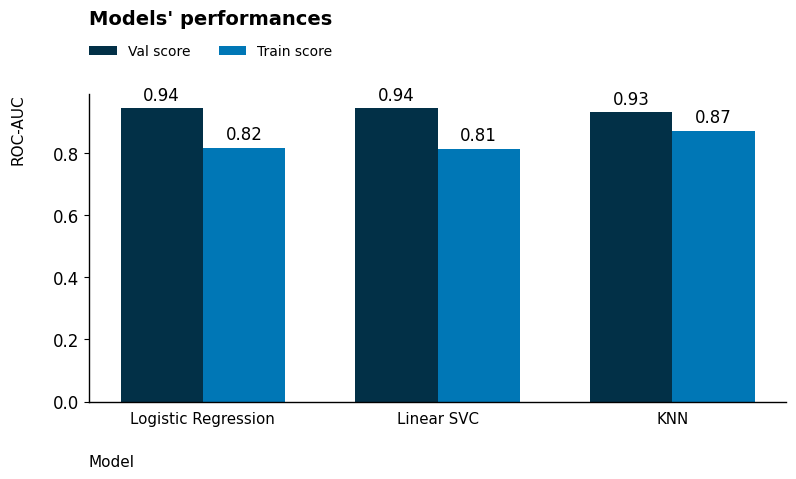

In [19]:
# Validação cruzada K-fold para modelos lineares.
eval_df = classification_kfold_cv(models=linear_models, 
                                  X_train=X_train_prepared_linear, 
                                  y_train=y_train, 
                                  n_folds=5)

plot_classification_kfold_cv(eval_df, bar_width=0.35, figsize=(9, 4), title_size=14, legend_x=0.175, legend_y=1.2, title_pad=50)

eval_df

Decision Tree results: 
--------------------------------------------------
Training score: 1.0
Average validation score: 0.8736833330922265
Standard deviation: 0.011170211033113542
Training time: 0.47815 seconds

Random Forest results: 
--------------------------------------------------
Training score: 1.0
Average validation score: 0.9883833855849531
Standard deviation: 0.002580004859168409
Training time: 4.00927 seconds

[LightGBM] [Info] Number of positive: 1302, number of negative: 6799
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5536
[LightGBM] [Info] Number of data points in the train set: 8101, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.160721 -> initscore=-1.652874
[LightGBM] [Info] Start training from score -1.652874
[LightGBM] [Info] Number of positive: 1041, number of negative: 5439
[LightGBM] [In

,model,avg_val_score,train_score
0,LightGBM,0.992292,1.0
1,Random Forest,0.988383,1.0
2,Decision Tree,0.873683,1.0


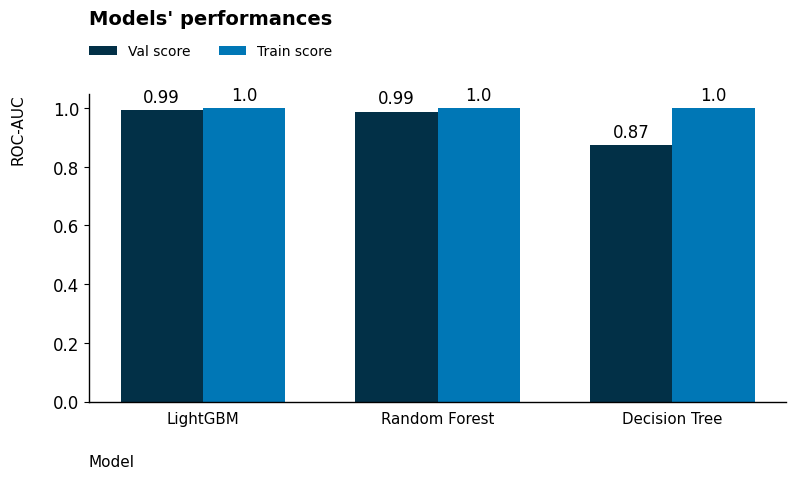

In [20]:
# Validação cruzada K-fold para modelos lineares.
eval_df = classification_kfold_cv(models=tree_models, 
                                  X_train=X_train_prepared_tree, 
                                  y_train=y_train, 
                                  n_folds=5)

plot_classification_kfold_cv(eval_df, bar_width=0.35, figsize=(9, 4), title_size=14, legend_x=0.175, legend_y=1.2, title_pad=50)

eval_df

Os resultados são ótimos. Irei com o LightGBM para seleção de recursos, ajuste de hiperparâmetros e avaliação final do modelo porque apresenta a maior pontuação média de validação ROC-AUC. Embora o modelo seja superajustado, com pontuação ROC-AUC de 1 nos dados de treinamento, sua pontuação de validação é muito próxima (0,99). Esse excelente desempenho não se deve ao vazamento de dados, uma vez que todos os recursos incluídos estão presentes no momento da previsão e a divisão foi feita antes de tudo. É devido à qualidade dos dados que as variáveis independentes separam claramente os que abandonam e os que não abandonam. Além disso, por causa do resultado, o ajuste de hiperparâmetros nem sequer acrescentaria qualquer desempenho. Porém, para demonstrar conhecimento, irei aplicá-lo.

### Seleção de recursos
- A etapa de seleção de características é crucial para melhorar a capacidade de generalização do modelo e torná-lo menos complexo, reduzindo assim os custos computacionais. Dado que temos 40 variáveis, simplificar o modelo sem perder desempenho é altamente vantajoso.

- Usarei o método Recursive Feature Elimination (RFE) para seleção de recursos.

- Eliminação recursiva de recursos (RFE) é um método de seleção de recursos que remove sistematicamente recursos irrelevantes ou menos importantes de um modelo preditivo. Ele funciona treinando recursivamente o modelo em subconjuntos de recursos, classificando-os com base em sua importância e eliminando os recursos menos importantes até que o número desejado de recursos seja alcançado

- Um hiperparâmetro importante do RFE é o número final desejado de recursos. Para selecionar automaticamente este valor, usarei a classe RFECV do sklearn. Ele aplicará validação cruzada estratificada k-fold para encontrar o melhor valor para este hiperparâmetro.

In [21]:
# Selecione recursivamente os recursos com maior importância até que o número final desejado de recursos seja obtido.
rfe = RecursiveFeatureEliminator(n_folds=5, 
                                 scoring='roc_auc',
                                 estimator=LGBMClassifier())
rfe.fit(X_train_prepared_tree, y_train)
X_train_selected = rfe.transform(X_train_prepared_tree)
X_train_selected.shape

[LightGBM] [Info] Number of positive: 1041, number of negative: 5439
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5528
[LightGBM] [Info] Number of data points in the train set: 6480, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.160648 -> initscore=-1.653413
[LightGBM] [Info] Start training from score -1.653413
[LightGBM] [Info] Number of positive: 1041, number of negative: 5439
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5524
[LightGBM] [Info] Number of data points in the train set: 6480, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.160648 -> initscore=-1.653413
[LightGBM] [Info] Start training from score -1.653413
[LightGBM] [Info] 

(8101, 25)

In [22]:
# Visualize as features finais selecionados.
X_train_selected.head()

,customer_age,contacts_count_12_mon,credit_limit,total_revolving_bal,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio,trans_amt_per_dependent,...,products_per_tenure,trans_ct_per_contacts,products_per_inactivity,trans_ct_per_inactivity,trans_amt_per_credit_limit,age_per_tenure,trans_ct_per_tenure,trans_amt_per_tenure,total_spending,education_income_levels
0,36.0,2.0,2570.0,2230.0,0.686,1755.0,42.0,0.448,0.868,0.000000,...,0.166667,21.000000,1.333333,14.000000,0.682879,1.500000,1.750000,73.125000,3985.0,0.0
1,44.0,3.0,25276.0,0.0,0.849,2282.0,38.0,0.583,0.000,760.666687,...,0.138889,12.666667,2.500000,19.000000,0.090283,1.222222,1.055556,63.388889,2282.0,3.0
2,46.0,1.0,11670.0,915.0,0.892,4277.0,89.0,0.854,0.078,2138.500000,...,0.200000,89.000000,2.000000,29.666666,0.366495,1.533333,2.966667,142.566666,5192.0,4.0
3,36.0,3.0,3124.0,1593.0,0.869,1652.0,41.0,0.367,0.510,826.000000,...,0.125000,13.666667,3.000000,41.000000,0.528809,1.500000,1.708333,68.833336,3245.0,3.0
4,50.0,3.0,34516.0,1185.0,0.725,3874.0,72.0,0.714,0.034,3874.000000,...,0.100000,24.000000,2.000000,36.000000,0.112238,1.250000,1.800000,96.849998,5059.0,7.0


In [23]:
X_train_selected.columns.tolist()

['customer_age',
 'contacts_count_12_mon',
 'credit_limit',
 'total_revolving_bal',
 'total_amt_chng_q4_q1',
 'total_trans_amt',
 'total_trans_ct',
 'total_ct_chng_q4_q1',
 'avg_utilization_ratio',
 'trans_amt_per_dependent',
 'trans_ct_per_dependent',
 'trans_amt_per_products',
 'trans_ct_per_products',
 'avg_trans_amt',
 'proportion_inactive_months',
 'products_per_tenure',
 'trans_ct_per_contacts',
 'products_per_inactivity',
 'trans_ct_per_inactivity',
 'trans_amt_per_credit_limit',
 'age_per_tenure',
 'trans_ct_per_tenure',
 'trans_amt_per_tenure',
 'total_spending',
 'education_income_levels']

- Como podemos ver, foram mantidas features que apresentavam uma clara discriminação entre desistentes e não desistentes, como total_trans_ct e total_trans_amt. Além disso, muitas features criadas a partir da engenharia de features também foram mantidas, demonstrando a importância desta tarefa para o desempenho do modelo.

- Como resultado, passamos de 40 features para 25 features finais mais importantes, reduzindo significativamente a complexidade computacional.

### Ajuste de hiperparâmetros
- Ajustarei os hiperparâmetros do LightGBM usando otimização Bayesiana através da biblioteca optuna.

- A otimização bayesiana realiza pesquisas inteligentes no espaço de hiperparâmetros do modelo, equilibrando o compromisso exploração-exploração.

- A pesquisa em grade é ineficiente porque realiza uma pesquisa exaustiva, testando todas as combinações possíveis de parâmetros e não considerando os efeitos de interação dos parâmetros. Isso seria prejudicial no nosso caso, pois o conjunto de dados de treinamento é extenso e parâmetros como número de árvores e taxa de aprendizado estão relacionados a outros.

- Em cada iteração, treinaremos o modelo com os parâmetros do conjunto de treinamento e o avaliaremos com validação cruzada estratificada k-fold para evitar overfitting resultante do ajuste excessivo de hiperparâmetros no conjunto de treinamento.

- É importante definir o hiperparâmetro scale_pos_weight/class_weight para lidar com o desequilíbrio. Este hiperparâmetro permitirá ao modelo aprender melhor os padrões da classe minoritária (ausente (1)) dando maior peso a essas instâncias. Esse peso aumentará o custo da perda de log ao classificá-los incorretamente, resultando em melhor aprendizado nesta classe.

- O ajuste de hiperparâmetros representa um refinamento. O que melhora consideravelmente o desempenho do modelo é a etapa de engenharia de recursos.

- Como mencionei antes, dado o excelente desempenho do nosso modelo nesses dados de alta qualidade, o ajuste de hiperparâmetros nem seria necessário. Porém, para demonstrar conhecimento, irei realizá-lo.

- A referência adotada para escolha dos hiperparâmetros pode ser encontrada no link a seguir. Normalmente, um número maior de árvores e iterações seria definido. No entanto, dadas as limitações do meu computador, estes parâmetros serão reduzidos.

- https://www.linkedin.com/posts/pedro-almeida-ds_voc%C3%AA-fica-perdido-sobre-quais-combina%C3%A7%C3%B5es-activity-7168232226965385216-bvtw?utm_source=share&utm_medium=member_desktop

In [24]:
def objective(trial):
    # Defina o espaço de pesquisa do hiperparâmetro.
    params = {
        'objective': 'binary',
        'metric': 'roc_auc',
        'n_estimators': 1000,
        'verbosity': -1,
        'bagging_freq': 1,
        'class_weight': 'balanced', 
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 2**10),
        'subsample': trial.suggest_float('subsample', 0.05, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.05, 1.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
    }

    # Treine o modelo LightGBM com os hiperparâmetros amostrados.
    model = LGBMClassifier(**params)
    
    # Obtenha a pontuação roc-auc média estratificada de validação cruzada k-fold.
    stratified_kfold = StratifiedKFold(n_splits=5, 
                                       shuffle=True, 
                                       random_state=42)
    val_scores = cross_val_score(model, 
                                 X_train_selected, 
                                 y_train, 
                                 scoring='roc_auc', 
                                 cv=stratified_kfold)
    avg_roc_auc = val_scores.mean()
    
    return avg_roc_auc

# Crie um estudo Optuna
study = optuna.create_study(direction='maximize')

# Otimize a função objetivo
study.optimize(objective, n_trials=10)

# Obtenha os melhores hiperparâmetros
best_params = study.best_params
print("Best Hyperparameters:", best_params)

[I 2024-04-12 18:28:16,492] A new study created in memory with name: no-name-0f7d3340-0e3d-4b32-8b99-02f002f785fa
[I 2024-04-12 18:28:37,353] Trial 0 finished with value: 0.9861980976455099 and parameters: {'learning_rate': 0.0028496712001860078, 'num_leaves': 500, 'subsample': 0.866151933166713, 'colsample_bytree': 0.11998260308684733, 'min_data_in_leaf': 25}. Best is trial 0 with value: 0.9861980976455099.
[I 2024-04-12 18:29:07,209] Trial 1 finished with value: 0.9926605973835135 and parameters: {'learning_rate': 0.03935267642825926, 'num_leaves': 897, 'subsample': 0.5635165633607456, 'colsample_bytree': 0.43982457121413016, 'min_data_in_leaf': 11}. Best is trial 1 with value: 0.9926605973835135.
[I 2024-04-12 18:29:28,003] Trial 2 finished with value: 0.9834393714333327 and parameters: {'learning_rate': 0.001110882755344135, 'num_leaves': 680, 'subsample': 0.5363609162869372, 'colsample_bytree': 0.12577850521200484, 'min_data_in_leaf': 17}. Best is trial 1 with value: 0.99266059738

Best Hyperparameters: {'learning_rate': 0.04207706480276948, 'num_leaves': 371, 'subsample': 0.7847719525540868, 'colsample_bytree': 0.5227694175096397, 'min_data_in_leaf': 54}


### 7. Teste e avaliação do modelo de produção final
- Nesta etapa, pretendo avaliar nosso modelo final ajustado em dados de teste (simulando dados de produção não vistos).

- Uma vez que estou enfrentando um problema de classificação binária com um alvo desequilibrado, é importante observar métricas como ROC-AUC. Quero que meu modelo discrimine bem entre desistentes e não desistentes.

- Como o objetivo do projeto é ordenar os clientes pela probabilidade de churn, não é necessário calibrar as probabilidades. Os resultados do modelo satisfazem nosso objetivo.

- Após avaliar o modelo, interpretarei seus resultados.

Obtenha o modelo LightGBM final ajustado.

In [25]:
best_params = {'objective': 'binary',
               'metric': 'roc_auc',
               'n_estimators': 1000,
               'verbosity': -1,
               'bagging_freq': 1,
               'class_weight': 'balanced', 
               'learning_rate': 0.017535345166904838,
               'num_leaves': 942,
               'subsample': 0.8490611533540497,
               'colsample_bytree': 0.3775159533799494,
               'min_data_in_leaf': 90}

lgb_clf = LGBMClassifier(**best_params)
lgb_clf.fit(X_train_selected, y_train)

LGBMClassifier(bagging_freq=1, class_weight='balanced',
               colsample_bytree=0.3775159533799494,
               learning_rate=0.017535345166904838, metric='roc_auc',
               min_data_in_leaf=90, n_estimators=1000, num_leaves=942,
               objective='binary', subsample=0.8490611533540497, verbosity=-1)

Use o pré-processador para transformar o conjunto de preditores de teste. Ao aplicar apenas a transformação evitamos o vazamento de dados.

In [26]:
X_test_prepared = tree_preprocessor.transform(X_test)
X_test_selected = rfe.transform(X_test_prepared)
X_test_selected.shape

(2026, 25)

Predict.

In [27]:
y_pred = lgb_clf.predict(X_test_selected)

Obtenha as probabilidades estimadas de churn do modelo.

In [28]:
churn_probas = lgb_clf.predict_proba(X_test_selected)[:, 1]

### Avalie o modelo LightGBM final ajustado.

In [33]:
model_metrics = evaluate_classifier(y_test, y_pred, churn_probas)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1701
           1       0.90      0.89      0.89       325

    accuracy                           0.97      2026
   macro avg       0.94      0.94      0.94      2026
weighted avg       0.97      0.97      0.97      2026



CustomException: An error occurred in python file [C:\Workspace\Churn-Prediction-Credit-Card\src\modelling_utils.py] line number [665] error message [name 'accuracy_score' is not defined]

In [31]:
model_metrics

NameError: name 'model_metrics' is not defined

The model results are excellent!

<b>Recall (0.89):</b> The model correctly identifies 89% of the churners. In practical terms, looking at the confusion matrix, it has accurately predicted 290 out of 325 attrited customers.<br>
<b>Precision (0.90):</b> Out of all customers predicted as churn, 90% of them are actually churners. In practical terms, considering the confusion matrix, out of 324 customers predicted as churn, 290 of them are indeed churners.<br>
<b>ROC-AUC (0.99):</b> With a ROC-AUC score of 0.99, the model demonstrates outstanding ability to differentiate between attrited and existing customers. In practive, if we randomly choose a customer that churned and a customer that dind't churn, in 99% of the time the model will estimate a higher probability of churn for that customer who actually attrited.
- This outstanding performance is not because data leakage, once all the features included are present at the moment of prediction and the split was made before everything. It is due to the quality of the data, the independent variables clearly separate churners and non-churners.
- Finally, once the train, test and validation scores are similar, the model's generalization ability is reliable.

- Analyze the predicted probabilities distribution by churn.

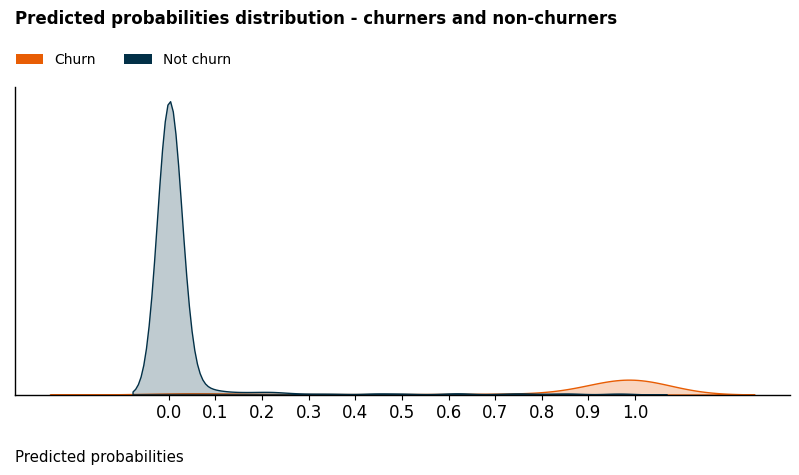

In [34]:
plot_probability_distributions(y_test, churn_probas)

- É possível perceber que existe uma clara separação entre as distribuições das probabilidades previstas para desistentes e não desistentes. Ótimo!

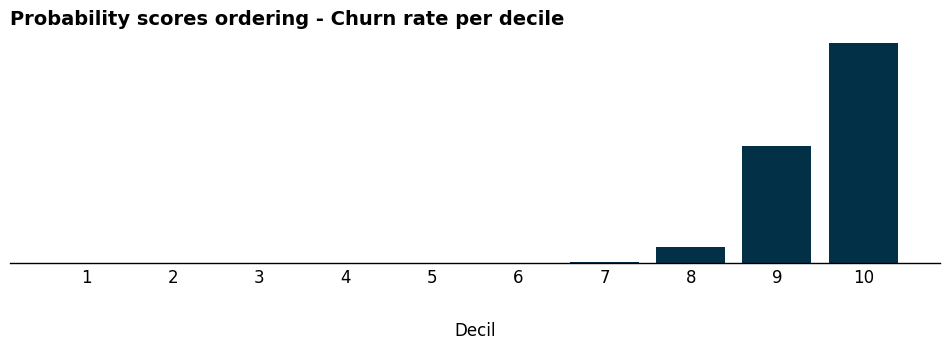

In [35]:
probability_scores_ordering(y_test, churn_probas)

- A ordem das pontuações de probabilidade também é ótima. Todos os churners ficam entre o 7º e o 10º decis.

### Interprete os resultados do modelo com valores SHAP
- Para interpretar os resultados do LightGBM, irei analisar os valores SHAP.
- SHAP é uma biblioteca que permite a interpretação de resultados de algoritmos de aprendizado de máquina.
- Com ele, podemos entender o impacto de cada recurso na previsão de um modelo individual. f(x) = E(f(x)) + SHAP.
- Basicamente, o valor SHAP de um recurso (quanto ele impacta uma previsão individual) é a soma ponderada das contribuições marginais considerando todas as coalizões de recursos possíveis.
- Uma coalizão de recursos é um grupo de recursos e seu valor é a previsão do modelo individual usando apenas esses recursos.
- A contribuição marginal de um recurso é a diferença entre o valor previsto para uma coalizão de recursos com e sem ele.
- Somamos as contribuições marginais para todas as combinações possíveis com e sem recurso.
- Os pesos são baseados na probabilidade do recurso que estamos calculando o valor SHAP estar nessa combinação.

In [36]:
# Initialize the SHAP explainer with the final model.
explainer = shap.Explainer(lgb_clf)

# Compute shap values.
shap_values = explainer(X_test_selected)

In [37]:
# Assess the shape.
np.shape(shap_values.values)

(2026, 25)

In [38]:
# Assess some true labels.
y_test.reset_index(drop=True).sample(10, random_state=42)

1284    0
982     0
1542    1
593     0
1292    1
781     0
1576    0
367     0
1782    0
1788    0
Name: churn_flag, dtype: int64

- Temos 25 variáveis. Para cada um, temos um valor SHAP correspondente para cada observação.

- Para classificação binária, interpretamos os resultados em termos de log-odds. Nos gráficos a seguir, E(f(X)) representa a previsão média das probabilidades logarítmicas. Log-odds é basicamente o logaritmo das probabilidades, a razão entre a probabilidade de o evento acontecer e a probabilidade de o evento não acontecer. O logaritmo é usado para converter probabilidades em uma escala linear. Valores positivos de SHAP aumentam as probabilidades logarítmicas e, consequentemente, a probabilidade de agitação e vice-versa.

- Para obter a probabilidade de rotatividade a partir das probabilidades logarítmicas, basta passar pela função logística, definida como $$ \text{sigmoid}(x) = \frac{1}{1 + e^{-\ln\left( \frac{p}{1-p}\direita)}} $$

- Através do gráfico em cascata, visualizaremos a contribuição de cada recurso na previsão para uma instância positiva (churner) e negativa (não churner).

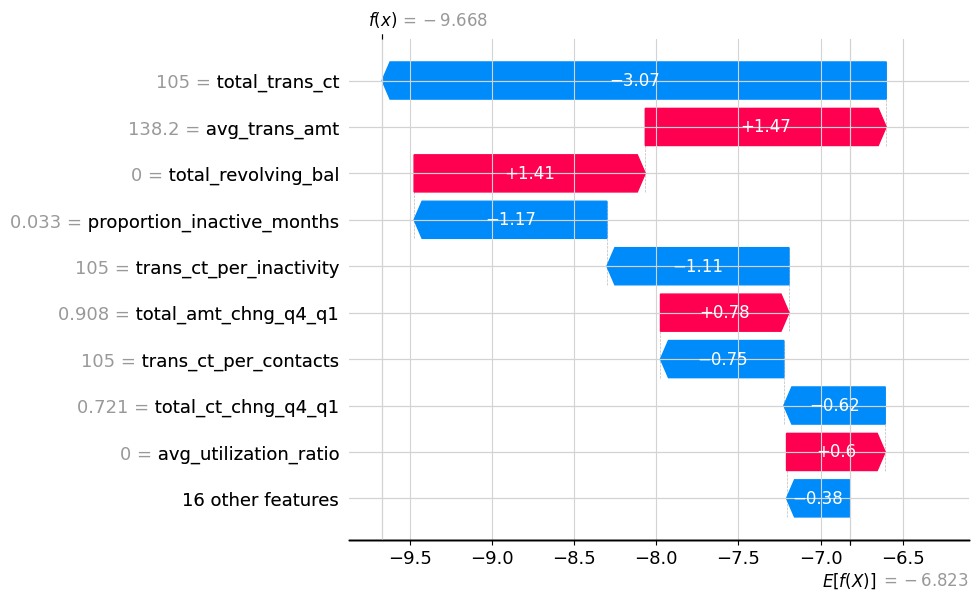

In [39]:
shap.plots.waterfall(shap_values[1])

- Este cliente não desistiu. A probabilidade estimada de rotatividade para ele por meio da função logística é muito próxima de zero,
- É possível perceber que o número de transações realizadas (nos últimos 12 meses), que neste caso é igual a 105, reduziu em 3,07 o log-odds de churnning. Em contrapartida, o saldo rotativo total, que é zero, aumentou as probabilidades logarítmicas de rotatividade em 1,41. Isso faz total sentido, pois vimos que quanto maior o número de transações menor o risco de churn, e muitos churners estavam concentrados em valores nulos de saldo rotativo total e taxa de utilização média.
- Veja como os recursos que criamos na engenharia de recursos impactaram negativa ou positivamente as chances de desligamento, em proporção_inactive_months e trans_ct_per_inactivity, por exemplo.

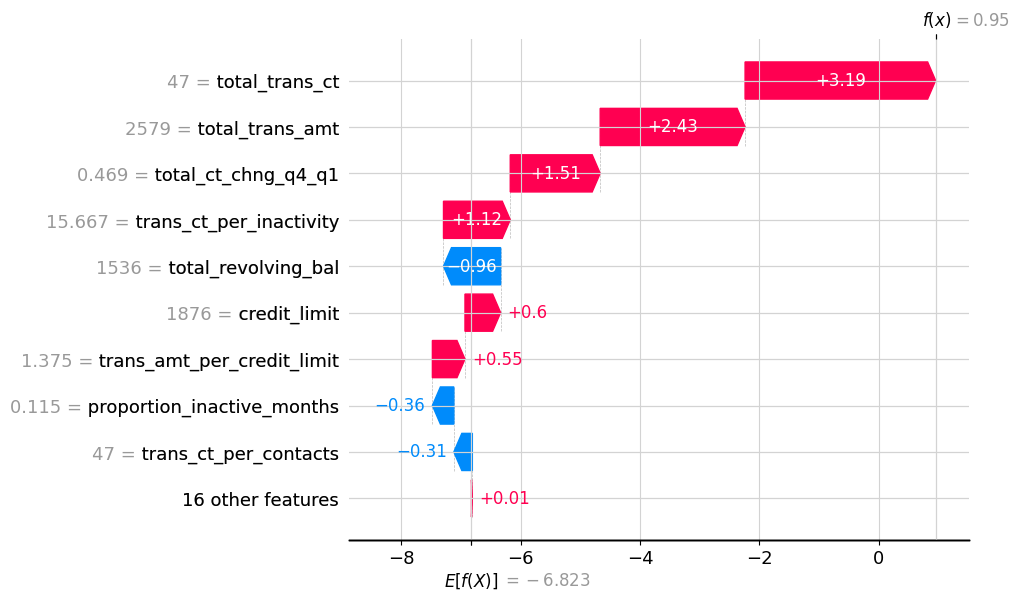

In [40]:
shap.plots.waterfall(shap_values[1542])

- Este cliente se agitou. A probabilidade estimada de rotatividade para ele por meio da função logística mencionada é de cerca de 72%.
- É possível observar que, novamente, o número de transações (nos últimos 12 meses) aumentou o log-odds of churnning em 3,19, o que faz todo o sentido, como mencionado anteriormente.

- Agora, através do gráfico de barras, observaremos quais características são mais importantes. Neste gráfico, temos o valor SHAP absoluto médio para cada característica, indicando quais características contribuem mais (positiva ou negativamente) para as previsões do modelo.

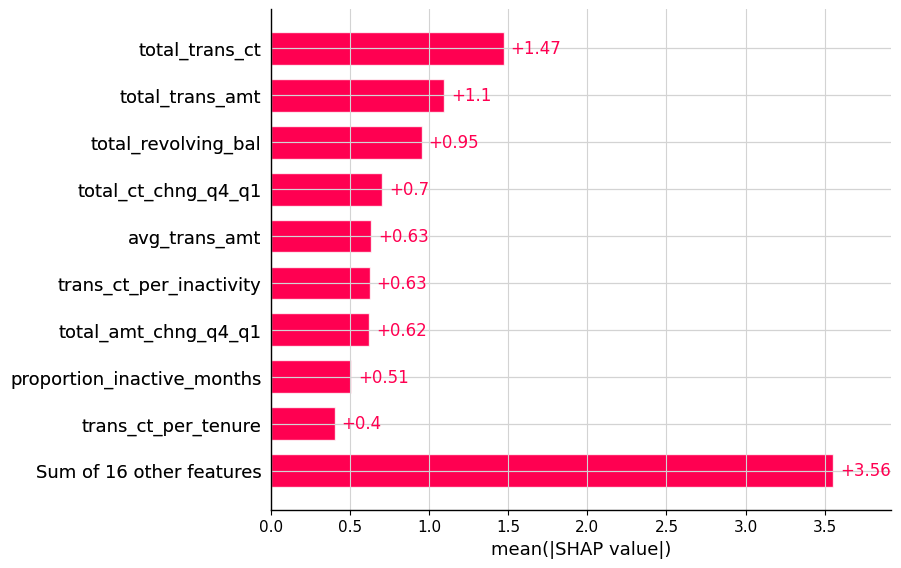

In [41]:
shap.plots.bar(shap_values)

- Como esperado, o número de transações e a quantidade de transações nos últimos 12 meses são as características mais importantes. Faz todo o sentido, e vimos na eda que essas variáveis apresentavam uma clara discriminação entre desistentes e não desistentes. Além disso, os recursos que criamos na etapa de engenharia de recursos foram considerados alguns dos mais importantes, ilustrando a importância desta tarefa na melhoria do desempenho de um modelo de aprendizado de máquina. É o caso de trans_ct_per_inactivity e avg_trans_amt, por exemplo.

- Agora, através do gráfico beeswarm, podemos observar a relação entre as características e a previsão do modelo.

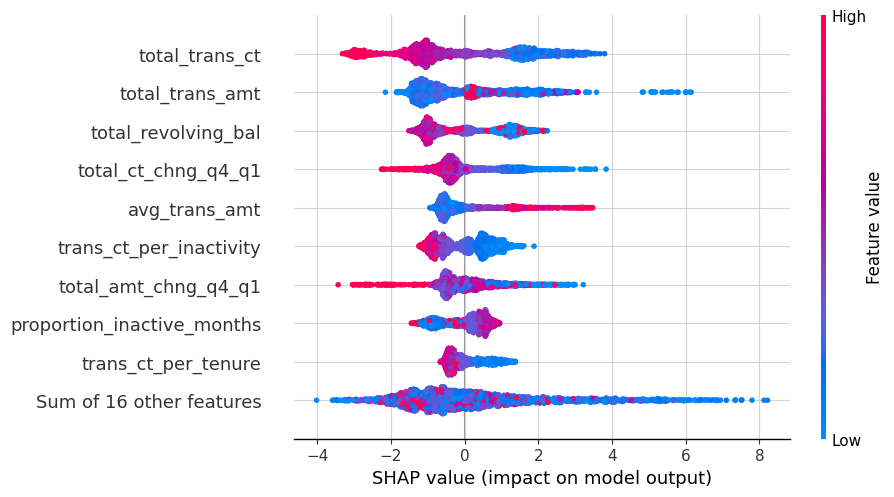

In [42]:
shap.plots.beeswarm(shap_values)

- É perceptível que valores mais baixos de contagens de transações nos últimos 12 meses têm um impacto positivo nas probabilidades logarítmicas de rotatividade e, consequentemente, na probabilidade de rotatividade, enquanto valores mais elevados têm um impacto negativo.

- Surpreendentemente, valores mais elevados do montante médio das transações tendem a refletir um impacto positivo nas probabilidades logarítmicas de rotatividade e, consequentemente, na probabilidade de rotatividade, enquanto valores mais baixos tendem a ter um impacto negativo.

### Resultados financeiros
- Vou expressar o desempenho do modelo em termos de resultados financeiros para o banco para mostrar que o projeto vale a pena. Farei isso observando a matriz de confusão e nossos dados atuais.
- Não tenho acesso a dados específicos para obter o ganho financeiro exato. No entanto, uma fonte de receita comum para as empresas de cartão de crédito é a cobrança de taxas sobre o saldo devedor, conhecido como saldo rotativo total, que os titulares do cartão carregam mês a mês. Assim, vou assumir que a tarifa do banco é de 18% (um valor comum) e calcular o ganho financeiro com ela.
- Considerando isso, para estimar o ganho financeiro proporcionado pelo modelo, levarei em consideração os seguintes custos e benefícios:
     1. Custo de retenção por cliente (falso positivo):
         - Esse custo se aplica a clientes que não abandonariam, mas foram erroneamente classificados como desistentes pelo modelo, levando o banco a incorrer em despesas para retê-los. Especificamente, para fidelizar o cliente, vou oferecer um desconto na tarifa, reduzindo-a de 18% para 10%, resultando em perda de receita devido a esse desconto de 8%.
     2. Perda de receita por churner (falso negativo):
         - Este custo surge quando os clientes que efetivamente vão abandonar não são corretamente identificados pelo modelo, levando o banco a perder estes clientes e as receitas associadas. Este custo abrangerá a totalidade da taxa (18%) aplicada aos saldos pendentes.
     3. Ganho financeiro com a retenção de um cliente corretamente previsto como churner (verdadeiro positivo):
         - Esse ganho ocorre quando o modelo prevê com precisão um churner, permitindo-nos retê-los junto com a receita que geram, aplicando a taxa de 10% sobre o total dos saldos rotativos como nossa estratégia de retenção.

Obtenha um conjunto de dados para resultados financeiros.

In [43]:
financial_results = pd.concat([X_test, y_test], axis=1)[['total_revolving_bal', 'churn_flag']]
financial_results['predicted'] = y_pred

Obtenha conjuntos de dados separados para custos de falsos positivos, falsos negativos e verdadeiros positivos e obtenha estimativas.

In [44]:
fp_data = financial_results.loc[(financial_results['churn_flag'] == 0) & (financial_results['predicted'] == 1)]
fn_data = financial_results.loc[(financial_results['churn_flag'] == 1) & (financial_results['predicted'] == 0)]
tp_data = financial_results.loc[(financial_results['churn_flag'] == 1) & (financial_results['predicted'] == 1)]

Estime os custos e ganhos.

In [45]:
fp_data['fp_cost'] = fp_data['total_revolving_bal']*1.18 - fp_data['total_revolving_bal']*1.10
fn_data['fn_cost'] = fn_data['total_revolving_bal']*1.18
tp_data['tp_gain'] = tp_data['total_revolving_bal']*1.10

Por fim, o resultado financeiro dado pelo modelo será a diferença entre o ganho e os custos.

In [47]:
financial_gain = tp_data['tp_gain'].sum() - fp_data['fp_cost'].sum() - fn_data['total_revolving_bal'].sum()
print(f'O modelo proporciona um ganho financeiro de: ${financial_gain:.1f}')

O modelo proporciona um ganho financeiro de: $171477.2


Uau! Nosso modelo gera um resultado financeiro estimado de aproximadamente US$ 171.477. O valor real dependerá da gestão do banco na implementação de estratégias de retenção de clientes com base nas probabilidades de rotatividade previstas. Por exemplo, se o banco pretender ser mais conservador, reduzindo despesas associadas a falsos positivos, pode visar clientes com maiores probabilidades de churn, alterando assim o ganho potencial. No entanto, para fins de estimativa e de base, confirmamos que o projeto vale a pena.

# 8. Conclusões
- Neste projeto, construí um classificador LightGBM para prever a probabilidade de desligamento do cliente no serviço de cartão de crédito de um banco. O objetivo do projeto era construir um modelo que fosse capaz de prever com precisão a probabilidade de desligamento de um cliente, descobrir os fatores de desligamento dentro dos recursos disponíveis e oferecer planos de ação para minimizar o problema. Fazendo isso, a empresa pode planejar estratégias de retenção, mantendo uma receita saudável. Conquistar novos clientes é mais caro do que manter os existentes.
- O problema comercial está resolvido agora. Meu modelo é capaz de prever corretamente 89% dos desistentes, com uma AUC de 0,99 e uma excelente capacidade de discriminar entre desistentes e não desistentes! Indica que, se escolhermos aleatoriamente um desistente e um não desistente, em 99% das vezes, o modelo estimará uma probabilidade maior de desistência para o cliente que realmente se desligou. Além disso, foi possível descobrir os principais fatores de rotatividade durante a etapa de EDA e fornecer algumas sugestões para o banco em relação aos padrões de atrito.
- Para lidar com o alvo desequilibrado, as estratégias utilizadas foram: hold-out estratificado e validação cruzada k-fold, e hiperparâmetro class_weight. Não pretendia usar o SMOTE porque na vida real não funciona. Meu objetivo aqui é simular um caso e uma solução reais de ciência de dados.
- Os resultados do modelo foram interpretados e são coerentes! Ao observar o formato, foi possível avaliar os recursos com maior poder preditivo para a análise e como eles impactam o resultado do modelo para uma única e todas as observações. Na etapa EDA, já havia pensado que esses recursos seriam os mais úteis, reforçando que os resultados do estimador fazem sentido. Finalmente, as probabilidades estimadas do modelo também fazem sentido e, portanto, tudo está funcionando bem.
- O projeto vale a pena. Ele fornece um resultado financeiro base estimado de aproximadamente US$ 171.477. O resultado concreto dependerá das taxas cobradas pelo banco e pela sua gestão na implementação de estratégias de retenção de clientes com base nas probabilidades de rotatividade previstas. No entanto, para fins de estimativa e de base, confirmamos que vale a pena.
- A próxima etapa é implantar o modelo usando princípios de pipeline CI/CD, com codificação modular.